## Visualization

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
stations = pd.read_csv("Divvy_Bicycle_Stations_20240722.csv")
trips = pd.read_csv("Divvy_Trips_20240721.csv")

In [3]:
outflows = trips[['FROM STATION ID', 'FROM STATION NAME']].copy()
outflows.rename(columns={'FROM STATION ID': 'STATION ID', 'FROM STATION NAME': 'STATION NAME'}, inplace=True)
outflows.drop_duplicates(inplace=True)

inflows = trips[['TO STATION ID', 'TO STATION NAME']].copy()
inflows.rename(columns={'TO STATION ID': 'STATION ID', 'TO STATION NAME': 'STATION NAME'}, inplace=True)
inflows.drop_duplicates(inplace=True)

In [4]:
stations_wid = pd.concat([outflows, inflows], ignore_index=True)
stations_wid.drop_duplicates(inplace=True)

stations_tmp = stations[['Station Name', 'Longitude', 'Latitude']].copy()
stations_tmp.rename(columns={'Station Name': 'STATION NAME', 'Longitude': 'LONGITUDE', 'Latitude': 'LATITUDE'}, inplace=True)
stations_wid = stations_wid.merge(stations_tmp, on='STATION NAME', how='inner')

In [5]:
station_results = pd.read_csv('station_results.csv')
stations_wid = stations_wid.merge(station_results, on='STATION ID', how='inner')

In [6]:
gdf_wid = gpd.GeoDataFrame(
    stations_wid,
    geometry=gpd.points_from_xy(stations_wid.LONGITUDE, stations_wid.LATITUDE),
    crs='EPSG:4326'
)

gdf_all = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude),
    crs='EPSG:4326'
)

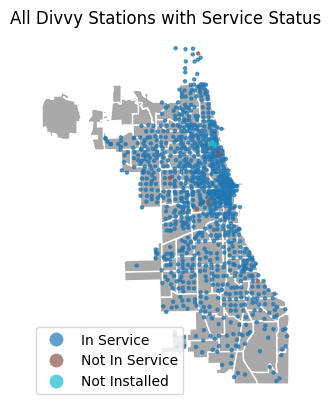

In [7]:
fig, ax = plt.subplots()
chicago = gpd.read_file('chicago-boundaries.geojson')
ax = chicago.plot(ax=ax, color='darkgrey', edgecolor='white')
ax = gdf_all.plot(ax=ax, marker='o', markersize=5, column="Status", legend=True, cmap='tab10', alpha=0.7)
ax.set_title('All Divvy Stations with Service Status')
ax.set_axis_off()
plt.savefig('all_stations.svg')
plt.show()

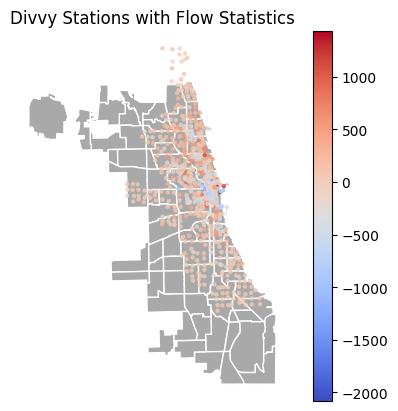

In [8]:
fig, ax = plt.subplots()
chicago = gpd.read_file('chicago-boundaries.geojson')
ax = chicago.plot(ax=ax, color='darkgrey', edgecolor='white')
gdf_wid.plot(ax=ax, marker='o', markersize=5, column="STATUS", legend=True, cmap='coolwarm', alpha=0.7)
ax.set_title('Divvy Stations with Flow Statistics')
ax.set_axis_off()
plt.savefig('wid_stations.svg')
plt.show()

### Path assignment

In [9]:
daily = pd.read_parquet('daily.parquet')

In [10]:
date_mode = daily.DATE.mode().item()  # select a day with most stations in service
date_mode

datetime.date(2019, 9, 19)

In [11]:
mode_result = daily[daily.DATE == date_mode]
mode_result = mode_result.merge(stations_wid, on='STATION ID', how='inner')[['STATION ID', 'STATION NAME', 'DAILY FLOW', 'LONGITUDE', 'LATITUDE']]

# select the top 5 stations with the most positive daily flow + top 5 stations with the most negative daily flow
mode_result_largest = mode_result[mode_result['DAILY FLOW'] > 0].nlargest(5, 'DAILY FLOW')
mode_result_smallest = mode_result[mode_result['DAILY FLOW'] < 0].nsmallest(5, 'DAILY FLOW')
mode_result = pd.concat([mode_result_largest, mode_result_smallest], ignore_index=True)

mode_result

,STATION ID,STATION NAME,DAILY FLOW,LONGITUDE,LATITUDE
0,114,Sheffield Ave & Waveland Ave,56,-87.654529,41.949399
1,91,Clinton St & Washington Blvd,31,-87.641170,41.883380
2,35,Streeter Dr & Grand Ave,30,-87.612043,41.892278
3,220,Clark St & Drummond Pl,27,-87.644336,41.931248
4,90,Millennium Park,23,-87.624084,41.881032
5,195,Columbus Dr & Randolph St,-84,-87.619521,41.884728
6,287,Franklin St & Monroe St,-42,-87.635185,41.880317
7,100,Orleans St & Merchandise Mart Plaza,-40,-87.636390,41.888243
8,174,Canal St & Madison St,-38,-87.639767,41.882409
9,191,Canal St & Monroe St,-38,-87.639530,41.881690


In [12]:
gdf_daily = gpd.GeoDataFrame(
    mode_result,
    geometry=gpd.points_from_xy(mode_result.LONGITUDE, mode_result.LATITUDE),
    crs='EPSG:4326'
)

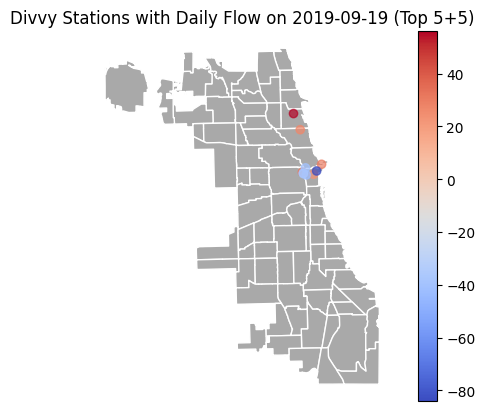

In [13]:
fig, ax = plt.subplots()
chicago = gpd.read_file('chicago-boundaries.geojson')
ax = chicago.plot(ax=ax, color='darkgrey', edgecolor='white')
gdf_daily.plot(ax=ax, column="DAILY FLOW", legend=True, cmap='coolwarm', alpha=0.7)
ax.set_title('Divvy Stations with Daily Flow on 2019-09-19 (Top 5+5)')
ax.set_axis_off()
plt.savefig('daily_stations.svg')
plt.show()

In [14]:
# build distance matrix
from geopy.distance import geodesic
import numpy as np

dist = np.zeros((len(mode_result), len(mode_result)))
for i in range(len(mode_result)):
    for j in range(len(mode_result)):
        dist[i, j] = geodesic((mode_result.LATITUDE[i], mode_result.LONGITUDE[i]), (mode_result.LATITUDE[j], mode_result.LONGITUDE[j])).m
dist.shape

(10, 10)

In [15]:
daily_flows = mode_result['DAILY FLOW'].values.tolist()
init_bikes = -mode_result['DAILY FLOW'].sum()
capacity = 100
print("Initial number of bikes needed to satisfy the demand:", init_bikes)
print("Max capacity to carry bikes:", capacity)

Initial number of bikes needed to satisfy the demand: 75
Max capacity to carry bikes: 100


Then we find a shortest path to fill all stations to 0 by searching (since a simpler case, Hamilton path, is NP-complete)

In [16]:
# algorithm part
paths = []
shortest_length = float('inf')

def path_length(path: list):
    length = 0
    for i in range(len(path) - 1):
        length += dist[path[i], path[i + 1]]
    return length

def dfs(bikes: int, capacity: int, remaining: set, visited: list, path: list):
    global shortest_length
    if len(remaining) == 0:
        pl = path_length(path)
        paths.append((path.copy(), pl))
        if pl < shortest_length:
            shortest_length = pl
    for node in remaining:
        if visited[node]:
            continue
        visited[node] = True
        path.append(node)
        if path_length(path) <= shortest_length:
            new_bikes = bikes + daily_flows[node]
            if new_bikes >= 0 and new_bikes <= capacity:
                new_remaining = remaining.copy()
                new_remaining.remove(node)
                dfs(new_bikes, capacity, new_remaining, visited, path)
        path.pop()
        visited[node] = False

dfs(init_bikes, capacity, set(range(len(mode_result))), [False] * len(mode_result), [])

In [17]:
paths.sort(key=lambda x: x[1])  # sort by path length
optimal_path = paths[0]  # the shortest path satisfying the demand
optimal_path

([4, 5, 2, 7, 3, 0, 8, 1, 9, 6], 19002.575031278582)

In [18]:
def plot_optimal_path(path, init_bikes, capacity):
    _, ax = plt.subplots()
    chicago = gpd.read_file('chicago-boundaries.geojson')
    ax = chicago.plot(ax=ax, color='darkgrey', edgecolor='white')
    gdf_daily.plot(ax=ax, column="DAILY FLOW", legend=True, cmap='coolwarm', alpha=0.7)
    ax.set_title(f'Divvy Stations with Daily Flow on 2019-09-19 (Top 5+5)\nOptimal Path, init_bikes={init_bikes}, capacity={capacity}', fontsize=10)
    ax.set_axis_off()
    ax.set_xlim(-87.68, -87.58)
    ax.set_ylim(41.87, 41.96)

    bikes = init_bikes
    for i in range(len(optimal_path[0]) - 1):
        bikes += daily_flows[path[i]]
        plt.text(mode_result.LONGITUDE[path[i]], mode_result.LATITUDE[path[i]], f'{bikes}', fontsize=8, color='black')
        x = mode_result.LONGITUDE[optimal_path[0][i]]
        y = mode_result.LATITUDE[optimal_path[0][i]]
        dx = mode_result.LONGITUDE[optimal_path[0][i + 1]] - x
        dy = mode_result.LATITUDE[optimal_path[0][i + 1]] - y
        plt.quiver(x, y, dx, dy, color='dimgrey', angles='xy', scale_units='xy', scale=1)

    bikes += daily_flows[optimal_path[0][-1]]
    plt.text(mode_result.LONGITUDE[path[-1]], mode_result.LATITUDE[path[-1]], f'{bikes}', fontsize=8, color='black')

    plt.savefig(f'daily_stations_with_path_i{init_bikes}_c{capacity}.svg')
    plt.show()

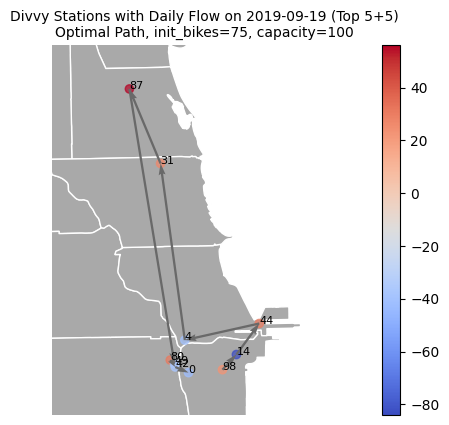

In [19]:
plot_optimal_path(optimal_path[0], init_bikes, capacity)

Now we change the setting to not restricting/restricting to minimum of the capacity

In [20]:
capacity = 10000
paths = []
shortest_length = float('inf')
dfs(init_bikes, capacity, set(range(len(mode_result))), [False] * len(mode_result), [])
paths.sort(key=lambda x: x[1])  # sort by path length
optimal_path = paths[0]  # the shortest path satisfying the demand
optimal_path

([0, 3, 2, 5, 4, 6, 9, 8, 1, 7], 11106.06188436581)

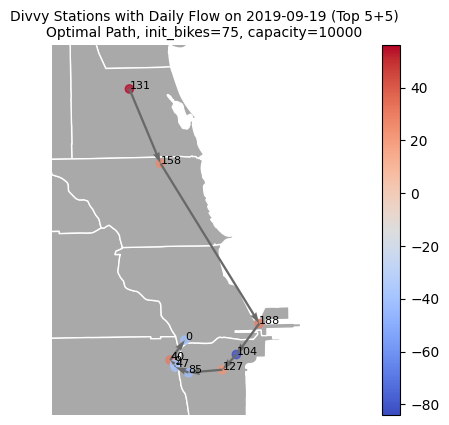

In [21]:
plot_optimal_path(optimal_path[0], init_bikes, capacity)

In [22]:
capacity = 84
paths = []
shortest_length = float('inf')
dfs(init_bikes, capacity, set(range(len(mode_result))), [False] * len(mode_result), [])
paths.sort(key=lambda x: x[1])  # sort by path length
optimal_path = paths[0]  # the shortest path satisfying the demand
optimal_path

([9, 1, 8, 2, 4, 6, 7, 0, 3, 5], 21055.549406009974)

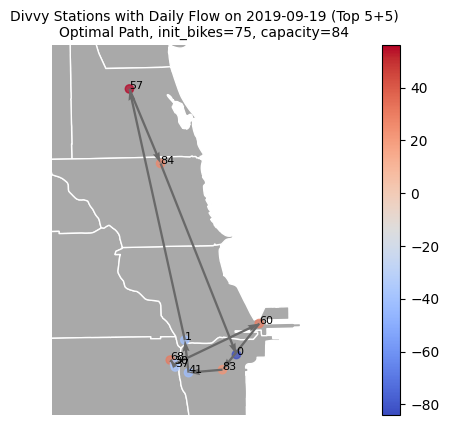

In [23]:
plot_optimal_path(optimal_path[0], init_bikes, capacity)

## kNN

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             accuracy_score, roc_auc_score, RocCurveDisplay)

In [25]:
stations_knn = stations_wid[['STATION ID', 'LATITUDE', 'LONGITUDE', 'RESULT']].copy()
stations_knn['RESULT'] = stations_knn['RESULT'].apply(lambda x: 1 if x == 'OVERFLOW' else -1 if x == 'UNDERFLOW' else 0)

In [26]:
clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
X = stations_knn[['STATION ID', 'LONGITUDE', 'LATITUDE']]
y = stations_knn['RESULT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
clf.fit(X_train[['LONGITUDE', 'LATITUDE']], y_train)
print(f"Accuracy on training data is {clf.score(X_train[['LONGITUDE', 'LATITUDE']], y_train):.3}")

Accuracy on training data is 0.793


Accuracy on test data is 0.591
Precision on test data is 0.661
Recall on test data is 0.591
AUC on test data is 0.648
Confusion matrix:
    0   1
0  29  20
1  27  39


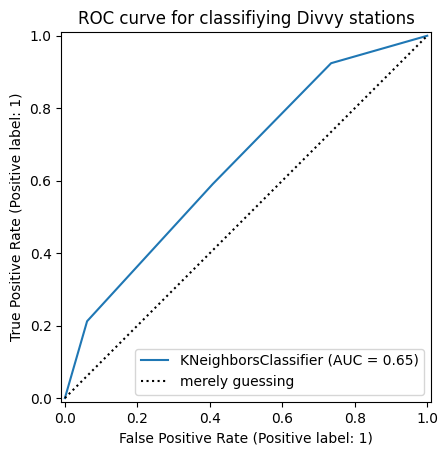

In [28]:
y_hat = clf.predict(X_test[['LONGITUDE', 'LATITUDE']])
print(f"Accuracy on test data is {accuracy_score(y_test, y_hat):.3}")
print(f"Precision on test data is {precision_score(y_test, y_hat):.3}")
print(f"Recall on test data is {recall_score(y_test, y_hat):.3}")

probability_y_is_1 = clf.predict_proba(X_test[['LONGITUDE', 'LATITUDE']])[:, 1]
print(f"AUC on test data is {roc_auc_score(y_test, probability_y_is_1):.3}")

print(f"Confusion matrix:\n{pd.DataFrame(confusion_matrix(y_test, y_hat))}")

RocCurveDisplay.from_estimator(clf, X_test[['LONGITUDE', 'LATITUDE']], y_test)
plt.plot([0, 1], [0, 1], ':k', label='merely guessing')
plt.title('ROC curve for classifiying Divvy stations')
plt.legend()
plt.show()

### kNN demo

In [29]:
pred_result = pd.DataFrame({'STATION ID': X_test['STATION ID'], 'PREDICTION': y_hat})
pred_result = pred_result.merge(stations_knn[['STATION ID', 'LATITUDE', 'LONGITUDE', 'RESULT']], on='STATION ID', how='inner')
pred_result["MATCH"] = pred_result["PREDICTION"] == pred_result["RESULT"]
pred_result

,STATION ID,PREDICTION,LATITUDE,LONGITUDE,RESULT,MATCH
0,88,1,41.884211,-87.654254,1,True
1,68,-1,41.875885,-87.640795,-1,True
2,87,-1,41.925566,-87.658416,-1,True
3,16,1,41.909855,-87.669930,-1,False
4,45,-1,41.876243,-87.624426,-1,True
...,...,...,...,...,...,...
110,126,-1,41.911974,-87.631942,1,False
111,211,1,41.894345,-87.622798,1,True
112,640,1,41.949923,-87.713949,1,True
113,591,-1,41.947071,-87.740008,1,False


In [30]:
gdf_test = gpd.GeoDataFrame(
    pred_result,
    geometry=gpd.points_from_xy(pred_result.LONGITUDE, pred_result.LATITUDE),
    crs='EPSG:4326'
)

In [31]:
gdf_train = gpd.GeoDataFrame(
    X_train,
    geometry=gpd.points_from_xy(X_train.LONGITUDE, X_train.LATITUDE),
    crs='EPSG:4326'
)

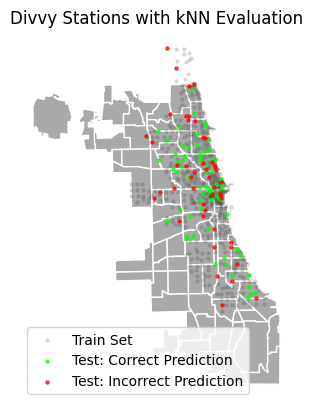

In [32]:
# plot the wrong predictions
fig, ax = plt.subplots()
chicago = gpd.read_file('chicago-boundaries.geojson')
ax = chicago.plot(ax=ax, color='darkgrey', edgecolor='white')
gdf_train.plot(ax=ax, marker='o', markersize=5, color='black', alpha=0.1)
gdf_test[gdf_test['MATCH'] == True].plot(ax=ax, marker='o', markersize=5, color='lime', alpha=0.7)
gdf_test[gdf_test['MATCH'] == False].plot(ax=ax, marker='o', markersize=5, color='red', alpha=0.7)
ax.set_title('Divvy Stations with kNN Evaluation')
ax.set_axis_off()
ax.legend(['Train Set', 'Test: Correct Prediction', 'Test: Incorrect Prediction'])
plt.savefig('knn_test.svg')
plt.show()